#**Trabajo Practico N2 - Inteligencia Artificial: Clasificacion de imágenes satelitales** 🛰






In [ ]:
#Los datos fueron subidos a un Google Drive personal, dentro de una carpeta llamada "data". Lo que haremos más adelante será recuperar esa carpeta para importarla en Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **📚Librerias utiles**

In [ ]:
import cv2 #para el procesamiento y manipulación de imágenes y videos en tiempo real.
import numpy as np #para el manejo de arreglos multidimensionales, matrices y funciones matemáticas.
import pandas as pd #permite la manipulación de datos tabulares y series temporales de manera eficiente.
import matplotlib.pyplot as plt  # para  gráficos, histogramas, espectros de potencia, entre otros.
import os #manipular archivos

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from IPython import display # Permite mostrar imágenes, videos, audio, y visualizaciones en notebooks.


display.set_matplotlib_formats('svg')#gráficos más nítidos


<ipython-input-134-b3be9ffd69e6>:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')#gráficos más nítidos


## **📑Extraccion de datos para armar nuestro dataframe**




In [ ]:
# Creamos un dataframe vacio donde iran nuestros datos. Tendra la columna ruta de la imagen y la columna clase
data = pd.DataFrame(columns=['image_path', 'label'])

# Definimos las clases
labels = {'/content/drive/MyDrive/data/nublado' : 'nublado',
          '/content/drive/MyDrive/data/desierto' : 'desierto',
          '/content/drive/MyDrive/data/area_verde' : 'area_verde',
          '/content/drive/MyDrive/data/agua' : 'agua',
           }

# Extraemos las imagenes de las rutas
for folder in labels:
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        label = labels[folder]
        data = data.append({'image_path': image_path, 'label': label}, ignore_index=True)


# Lo guardamos en un CSV
data.to_csv('image_dataset.csv', index=False)

## **🔨Preprocesamiento de datos**


In [ ]:
# Cargamos el dataset
df = pd.read_csv("image_dataset.csv")

In [ ]:
# Lo visualizamos
df

,image_path,label
0,/content/drive/MyDrive/data/nublado/train_1653...,nublado
1,/content/drive/MyDrive/data/nublado/train_1766...,nublado
2,/content/drive/MyDrive/data/nublado/train_8608...,nublado
3,/content/drive/MyDrive/data/nublado/train_2766...,nublado
4,/content/drive/MyDrive/data/nublado/train_2138...,nublado
...,...,...
5626,/content/drive/MyDrive/data/agua/SeaLake_1238.jpg,agua
5627,/content/drive/MyDrive/data/agua/SeaLake_664.jpg,agua
5628,/content/drive/MyDrive/data/agua/SeaLake_1741.jpg,agua
5629,/content/drive/MyDrive/data/agua/SeaLake_1368.jpg,agua


In [ ]:
# Dividimos el dataset en datos de entrenamiento y de prueba (los datos de prueba seran el 20% del total de datos.)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=33)

In [ ]:
# Creamos un objeto ImageDataGenerator para el preprocesamiento y aumento de imágenes para el conjunto de entrenamiento.
# Esto ayuda a mejorar la generalización del modelo al proporcionar variaciones de las imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Reescala los valores de pixel a un rango de 0 a 1 para ayudar en la convergencia del entrenamiento.
    shear_range=0.2,          # Aplica una transformación de corte llamada shear para aumentar la variedad de las imágenes.
    zoom_range=0.2,           # Aplica un rango de zoom para aumentar la variedad de tamaños de imagen.
    horizontal_flip=True,     # Invierte horizontalmente las imágenes de manera aleatoria para aumentar la diversidad de datos.
    rotation_range=45,        # Rota las imágenes hasta 45 grados para aumentar la diversidad de datos.
    vertical_flip=True,       # Invierte verticalmente las imágenes de manera aleatoria para aumentar la diversidad de datos.
    fill_mode='nearest'       # Rellena los pixeles que podrían quedar vacíos después de transformaciones como la rotación.
)

# Creamos ahora un objeto ImageDataGenerator tambien para el preprocesamiento de imágenes para el conjunto de pruebas.
# En este caso, solo se reescalan los valores de los píxeles para que estén en el rango de 0 a 1.
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Bien, y ahora armamos generadores. Los generadores son necesarios para manejar grandes volúmenes de imágenes de manera eficiente,
# facilitan el preprocesamiento y el aumento de datos para mejorar la generalización del modelo.

# Utilizando flow_from_dataframe para cargar y preprocesar imágenes desde un dataframe para el conjunto de entrenamiento.
# Esto crea un generador que será utilizado para entrenar el modelo.
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Dataframe que contiene los datos.
    x_col="image_path",             # Columna del dataframe que contiene la ruta de las imágenes.
    y_col="label",                  # Columna del dataframe que contiene las etiquetas de las imágenes.
    target_size=(255, 255),         # Tamaño al que se redimensionarán las imágenes.
    batch_size=32,                  # Tamaño del lote de imágenes que se cargarán en la memoria y se pasarán al modelo durante el entrenamiento.
    class_mode="categorical"        # Modo de clasificación, "categorial" se utiliza para clasificación multiclase.
)

# Utilizando flow_from_dataframe para cargar y preprocesar imágenes desde un dataframe para el conjunto de pruebas.
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,              # Dataframe que contiene los datos.
    x_col="image_path",             # Columna del dataframe que contiene la ruta de las imágenes.
    y_col="label",                  # Columna del dataframe que contiene las etiquetas de las imágenes.
    target_size=(255, 255),         # Tamaño al que se redimensionarán las imágenes.
    batch_size=32,                  # Tamaño del lote de imágenes que se cargarán en la memoria y se pasarán al modelo durante el entrenamiento.
    class_mode="categorical"        # Modo de clasificación, "categorial" se utiliza para clasificación multiclase.
)


Found 4504 validated image filenames belonging to 4 classes.
Found 1127 validated image filenames belonging to 4 classes.


## **🧠Armado del 1er modelo RNA: CNN desde cero**

In [ ]:
# Armado del primer modelo

model = Sequential() # Los modelos secuenciales son una pila lineal de capas donde se puede añadir una capa tras otra.

# Primera capa convolucional.
# 32 es el número de filtros (o neuronas), (3,3) es el tamaño del filtro.
# input_shape=(255, 255, 3) define la forma de las imágenes de entrada: 255x255 píxeles y 3 canales (RGB).
# 'relu' es la función de activación que se usa para añadir no linearidad al modelo.
model.add(Conv2D(32, (3, 3), input_shape=(255, 255, 3), activation='relu'))

# Añadimos una segunda capa convolucional.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))

# Añadimos una capa de pooling para reducir las dimensiones espaciales de la salida.
# Usamos MaxPooling con un tamaño de ventana de 2x2.
model.add(MaxPooling2D(2, 2))

# Añadimos una tercera capa convolucional con 64 filtros.
model.add(Conv2D(64, (3, 3), activation='relu'))

# Añadimos otra capa de pooling.
model.add(MaxPooling2D(2, 2))

# Añadimos una cuarta capa convolucional con 128 filtros.
model.add(Conv2D(128, (3, 3), activation='relu'))

# Añadimos una tercera capa de pooling.
model.add(MaxPooling2D(2, 2))

# Aplanamos la salida de las capas convolucionales para introducirlas en capas densamente conectadas.
model.add(Flatten())

# Añadimos una capa densamente conectada (o completamente conectada) con 128 neuronas.
model.add(Dense(128, activation='relu'))

# Quisimos añadir una capa tipo Dropout para prevenir el sobreajuste.
# 0.5 indica que el 50% de las neuronas serán desactivadas aleatoriamente durante el entrenamiento.
model.add(Dropout(0.5))

# Añadimos la capa de salida con 4 neuronas (para 4 clases) usando 'softmax' para obtener probabilidades de clase.
model.add(Dense(4, activation='softmax'))


In [ ]:
# Compilamos el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Lo entrenamos
history = model.fit_generator(train_generator, epochs=5, validation_data=test_generator)

<ipython-input-143-81f399c29e54>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=5, validation_data=test_generator)


Epoch 1/5
141/141 [==============================] - 88s 598ms/step - loss: 0.6993 - accuracy: 0.6605 - val_loss: 0.4292 - val_accuracy: 0.8403
Epoch 2/5
141/141 [==============================] - 88s 627ms/step - loss: 0.4816 - accuracy: 0.7782 - val_loss: 0.5637 - val_accuracy: 0.7187
Epoch 3/5
141/141 [==============================] - 85s 605ms/step - loss: 0.5295 - accuracy: 0.7180 - val_loss: 0.4869 - val_accuracy: 0.7746
Epoch 4/5
141/141 [==============================] - 86s 609ms/step - loss: 0.5060 - accuracy: 0.7453 - val_loss: 0.5051 - val_accuracy: 0.7098
Epoch 5/5
141/141 [==============================] - 88s 622ms/step - loss: 0.4835 - accuracy: 0.7655 - val_loss: 0.5077 - val_accuracy: 0.8518


### **🎯Resultados del 1er modelo**

In [ ]:
num_samples = test_df.shape[0]
num_samples

1127

In [ ]:
score = model.evaluate(test_generator,
                       steps=num_samples//32+1,
                       )

36/36 [==============================] - 4s 110ms/step - loss: 0.5077 - accuracy: 0.8518


### **📈Funciones Loss y Accuracy del 1er modelo**

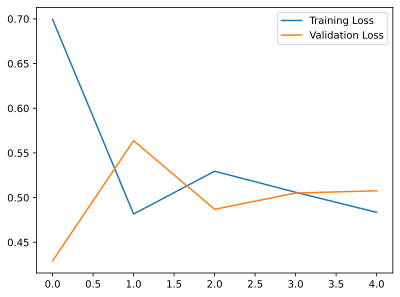

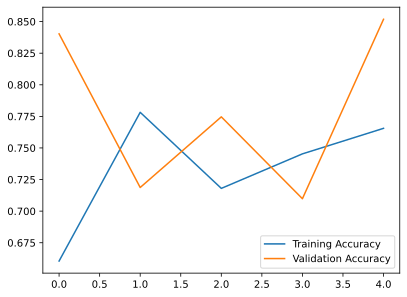

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

### **😵Matriz de confusión**

36/36 [==============================] - 3s 85ms/step


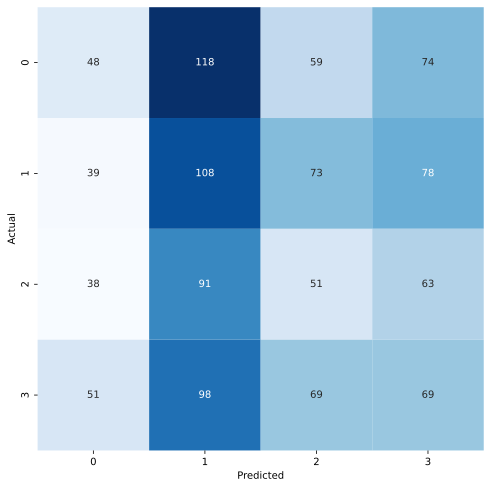

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtiene todas las etiquetas verdaderas del generador
true_labels = test_generator.classes

# Realiza predicciones
predictions = model.predict(test_generator, steps=num_samples//32+1)
predicted_labels = np.argmax(predictions, axis=1)

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualiza la matriz de confusión
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print(test_generator.class_indices)

{'agua': 0, 'area_verde': 1, 'desierto': 2, 'nublado': 3}


## **🧠Armado del 2do modelo RNA: Arquitectura CNN mejorada**

En nuestra revisión del modelo CNN inicial, hemos implementado varias mejoras significativas. Incrementamos el número de filtros en las capas convolucionales para capturar características más complejas y añadimos capas de normalización por lotes para mejorar la convergencia y estabilidad del modelo. Asimismo, ampliamos la capacidad del modelo incluyendo capas densas adicionales con un mayor número de neuronas. Para mitigar el sobreajuste, ajustamos la tasa de dropout a un 30%. También, introducimos el parámetro de 'padding' con valor 'same' en las capas convolucionales, asegurando así que se conserven las dimensiones espaciales, lo que permite a la red aprender características cruciales en los bordes de la imagen. Estos refinamientos están orientados a optimizar la precisión y la eficiencia del modelo en tareas de clasificación.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

# Primera capa convolucional
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(255, 255, 3), activation='relu'))
model.add(BatchNormalization())  # Capa de normalización por lotes
model.add(MaxPooling2D(2, 2))

# Segunda capa convolucional
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  # Capa de normalización por lotes
model.add(MaxPooling2D(2, 2))

# Tercera capa convolucional
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  # Capa de normalización por lotes
model.add(MaxPooling2D(2, 2))

# Cuarta capa convolucional
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  # Capa de normalización por lotes
model.add(MaxPooling2D(2, 2))

# Aplanado
model.add(Flatten())

# Primera capa densa
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))  # Ajustar la tasa de Dropout

# Segunda capa densa
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))  # Ajustar la tasa de Dropout

# Capa de salida
model.add(Dense(4, activation='softmax'))  # Asumiendo que hay 4 clases como en el modelo original


In [ ]:
# Compilamos el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Lo entrenamos
history = model.fit_generator(train_generator, epochs=5, validation_data=test_generator)

<ipython-input-151-81f399c29e54>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=5, validation_data=test_generator)


Epoch 1/5
141/141 [==============================] - 97s 652ms/step - loss: 23.0852 - accuracy: 0.7216 - val_loss: 28.9845 - val_accuracy: 0.5049
Epoch 2/5
141/141 [==============================] - 90s 638ms/step - loss: 7.7199 - accuracy: 0.7489 - val_loss: 1.9344 - val_accuracy: 0.5067
Epoch 3/5
141/141 [==============================] - 94s 666ms/step - loss: 1.0478 - accuracy: 0.7651 - val_loss: 1.1602 - val_accuracy: 0.2768
Epoch 4/5
141/141 [==============================] - 93s 657ms/step - loss: 0.7544 - accuracy: 0.7920 - val_loss: 0.6974 - val_accuracy: 0.5262
Epoch 5/5
141/141 [==============================] - 91s 642ms/step - loss: 0.6534 - accuracy: 0.8133 - val_loss: 0.3628 - val_accuracy: 0.8651


### **🎯Resultados del 2do modelo**

In [ ]:
num_samples = test_df.shape[0]
num_samples

1127

In [ ]:
score = model.evaluate(test_generator,
                       steps=num_samples//32+1,
                       )

36/36 [==============================] - 4s 102ms/step - loss: 0.3628 - accuracy: 0.8651


### **📈Funciones Loss y Accuracy del 2do modelo**

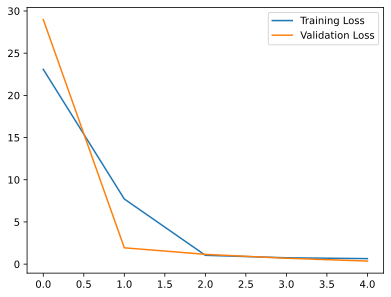

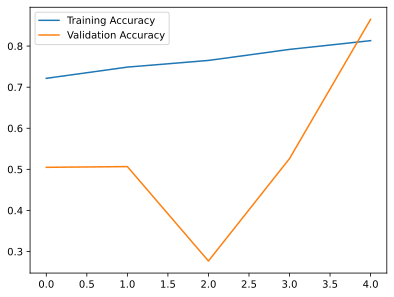

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

### **😵Matriz de confusion**

36/36 [==============================] - 3s 87ms/step


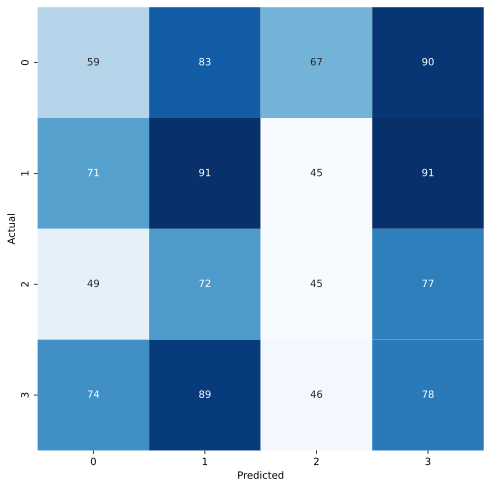

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtiene todas las etiquetas verdaderas del generador
true_labels = test_generator.classes

# Realiza predicciones
predictions = model.predict(test_generator, steps=num_samples//32+1)
predicted_labels = np.argmax(predictions, axis=1)

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualiza la matriz de confusión
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print(test_generator.class_indices)

{'agua': 0, 'area_verde': 1, 'desierto': 2, 'nublado': 3}


## **🧠Armado del 3er modelo RNA: RNA clásica multicapa**

El rendimiento de una red neuronal multicapa (MLP) no es óptimo para la clasificación de imágenes por varias razones:

1. **Pérdida de información espacial:** Cuando las imágenes se aplanan para alimentarlas en una MLP, se pierde la estructura espacial y la correlación entre los píxeles vecinos. Las redes neuronales convolucionales (CNN), por otro lado, mantienen y explotan esta estructura para identificar patrones locales.

2. **Capacidad para capturar patrones jerárquicos:** Las MLP no son muy efectivas para capturar patrones jerárquicos o estructuras espaciales complejas en imágenes. Las CNN pueden identificar patrones jerárquicos y estructuras espaciales complejas debido a sus capas convolucionales y de agrupamiento.

3. **Invarianza a la traslación:** Una MLP no maneja bien las variaciones en la posición y la orientación de los objetos dentro de las imágenes. Las CNN son más robustas a las transformaciones espaciales de los objetos en imágenes debido a su arquitectura.

5. **Eficiencia en el entrenamiento:** Las MLP pueden ser más lentas para entrenar en conjuntos de datos de imágenes grandes debido a la gran cantidad de parámetros y la falta de eficiencia en la captura de características visuales. Las CNN son más eficientes en este aspecto, particularmente para datos de imágenes.

In [ ]:
# Creando un modelo secuencial
model = Sequential()

# Añadiendo una capa Flatten para transformar la imagen 2D en un vector 1D
# Esto es necesario porque una MLP no puede aceptar entradas multidimensionales como una CNN
# input_shape=(255, 255, 3) indica que cada imagen tiene una dimensión de 255x255 píxeles con 3 canales de color (RGB)
model.add(Flatten(input_shape=(255, 255, 3)))

# Añadiendo una capa densa con 128 neuronas y función de activación ReLU
# Esto servirá como capa oculta para la red
model.add(Dense(128, activation='relu'))

# Añadiendo una capa Dropout para reducir el sobreajuste
# Esto desactiva aleatoriamente algunas neuronas durante el entrenamiento para mejorar la generalización
model.add(Dropout(0.5))

# Añadiendo la capa de salida con 4 neuronas (para un problema de clasificación con 4 clases)
# Se usa la función de activación softmax para convertir las salidas en probabilidades de clase
model.add(Dense(4, activation='softmax'))

# La estructura completa del modelo MLP
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 195075)            0         
                                                                 
 dense_38 (Dense)            (None, 128)               24969728  
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 4)                 516       
                                                                 
Total params: 24970244 (95.25 MB)
Trainable params: 24970244 (95.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compilamos el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Lo entrenamos
history = model.fit_generator(train_generator, epochs=5, validation_data=test_generator)

<ipython-input-159-81f399c29e54>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=5, validation_data=test_generator)


Epoch 1/5
141/141 [==============================] - 79s 556ms/step - loss: 5.9743 - accuracy: 0.3659 - val_loss: 1.0537 - val_accuracy: 0.5058
Epoch 2/5
141/141 [==============================] - 77s 548ms/step - loss: 1.2802 - accuracy: 0.3834 - val_loss: 1.1693 - val_accuracy: 0.3274
Epoch 3/5
141/141 [==============================] - 77s 546ms/step - loss: 1.1759 - accuracy: 0.4087 - val_loss: 0.9670 - val_accuracy: 0.6699
Epoch 4/5
141/141 [==============================] - 79s 556ms/step - loss: 1.1711 - accuracy: 0.4132 - val_loss: 0.9232 - val_accuracy: 0.6610
Epoch 5/5
141/141 [==============================] - 80s 570ms/step - loss: 1.2937 - accuracy: 0.4056 - val_loss: 0.9446 - val_accuracy: 0.6087


### **🎯Resultados del 3er modelo**

In [ ]:
num_samples = test_df.shape[0]
num_samples

1127

In [ ]:
score = model.evaluate(test_generator,
                       steps=num_samples//32+1,
                       )

36/36 [==============================] - 3s 94ms/step - loss: 0.9447 - accuracy: 0.6087


### **📈Funciones Loss y Accuracy del 3er modelo**

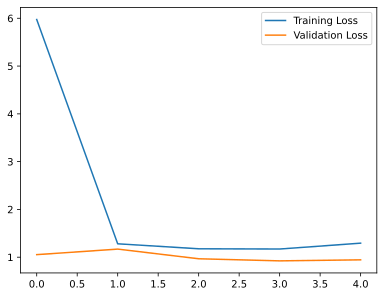

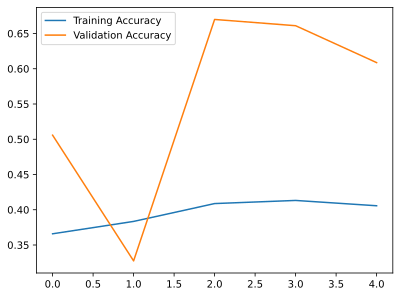

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

### **😵Matriz de confusion**

36/36 [==============================] - 3s 88ms/step


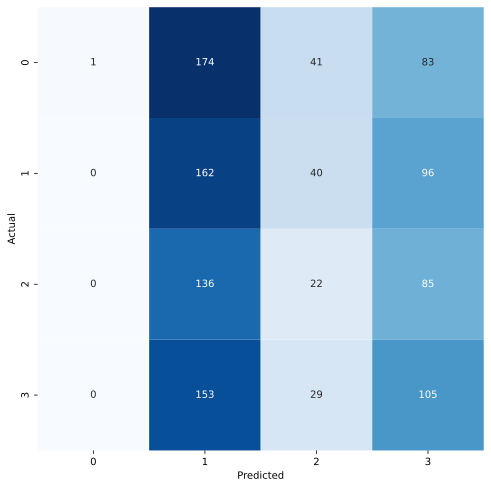

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtiene todas las etiquetas verdaderas del generador
true_labels = test_generator.classes

# Realiza predicciones
predictions = model.predict(test_generator, steps=num_samples//32+1)
predicted_labels = np.argmax(predictions, axis=1)

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualiza la matriz de confusión
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print(test_generator.class_indices)

{'agua': 0, 'area_verde': 1, 'desierto': 2, 'nublado': 3}
